In [441]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import comb

In [412]:
def get_bichromatic_ratio(g):
    bichromatic = 0
    for (x,y) in g.edges():
        if (x < size_maj) != (y < size_maj):
            bichromatic += 1
    return bichromatic / len(g.edges())

In [584]:
graph_size = 1000
maj_min_ratio = .5
size_maj = int(maj_min_ratio * graph_size)
size_min = int(graph_size - size_maj)
probs = [[0.05, 0.02],
         [0.02, 0.05]]
g = nx.generators.community.stochastic_block_model([size_maj, size_min], probs, seed=0)

In [585]:
def expected_bichromatic_wedges(n, p, q):
    return 2 * n * comb(n/2, 2) * p * q * (1-q)

In [566]:
def expected_monochromatic_wedges(n, p, q):
    return 3 * 2 * comb(n/2, 3) * p**2 * (1-p) + n * comb(n/2, 2) * q**2 * (1-p)

In [567]:
expected_bichromatic_wedges(graph_size, probs[0][0], probs[0][1])

592562.5

In [568]:
expected_monochromatic_wedges(graph_size, probs[0][0], probs[0][1])

591377.37500000012

In [569]:
expected_monochromatic_wedges(graph_size, probs[0][0], probs[0][1]) / (expected_monochromatic_wedges(graph_size, probs[0][0], probs[0][1]) + expected_bichromatic_wedges(graph_size, probs[0][0], probs[0][1]))

0.49949949949949962

In [572]:
iterations = 10
new_friends_per_iter = 1
alpha = 1

In [573]:
def get_group(node):
    if node < size_maj:
        return range(size_maj)
    else:
        return range(size_maj, graph_size)

In [593]:
def close_wedges(g, isalpha, alpha, iterations, new_friends_per_iter):
    bichromatic_ratios = [get_bichromatic_ratio(g)]
    for i in range(iterations):
        # Select random node
        node = np.random.randint(0, g.number_of_nodes())
        edges_added = 0
        # Add edges of friends of friends randomly
        while (edges_added < new_friends_per_iter):
            if isalpha:
                same_type = np.random.binomial(1, alpha)
                if same_type:
                    friends = set(nx.all_neighbors(g, node)).intersection(set(get_group(node)))
                else:
                    friends = set(nx.all_neighbors(g, node)).difference(set(get_group(node)))
            else:
                friends = set(nx.all_neighbors(g, node))
            if len(friends) > 0:
                friend = random.sample(friends, 1)[0]
                new_possible_friends = set(nx.all_neighbors(g, friend)).difference(set(nx.all_neighbors(g, node)))
                if len(new_possible_friends) > 0:
                    new_friend = random.sample(new_possible_friends, 1)[0]
                    g.add_edge(node, new_friend)
                    edges_added += 1
                else:
                    node = np.random.randint(0, g.number_of_nodes())
            else:
                node = np.random.randint(0, g.number_of_nodes())
        bichromatic_ratios.append(get_bichromatic_ratio(g))
    return bichromatic_ratios

In [598]:
def plot_bichromatic_ratios_sbm(sample_size, graph_size, maj_min_ratio, probs, iterations, new_friends_per_iter):
    size_maj = int(maj_min_ratio * graph_size)
    size_min = int(graph_size - size_maj)
    bichromatic_ratio_matrix = []
    for seed in range(sample_size):
        g = nx.generators.community.stochastic_block_model([size_maj, size_min], probs, seed=seed)
        bichromatic_ratio_matrix.append(close_wedges(g, False, 1, iterations, new_friends_per_iter))
    bichromatic_ratios = np.average(bichromatic_ratio_matrix, axis=0)
    print(bichromatic_ratios)
    plt.plot(range(len(bichromatic_ratios)), bichromatic_ratios)
    plt.xlabel("Iterations")
    plt.ylabel("Ratio of Bichromatic Edges")
    plt.title("Ratio of Bichromatic Edges for " + str(int(maj_min_ratio * 100)) + "% Majority, p=" +str(probs[0][0]) + " q=" + str(probs[0][1]))
    # plt.savefig("plots/bichromatic_ratio_maj_" + str(int(maj_min_ratio * 100)) + "g" + str(graph_size) + "_iters" + str(iterations) + "_type_bias" + "_alpha" + str(int(10 * alpha)))
    plt.savefig("plots/sbm_p=" + str(int(100*probs[0][0])) + "_q=" + str(int(100*probs[0][1])) + "biratio_maj_" + str(int(maj_min_ratio * 100)) + "g" + str(graph_size) + "_sample" + str(sample_size))
    plt.show()

[ 0.50045084  0.50045082  0.50045242  0.50045318  0.50045238  0.50045397
  0.50045554  0.5004539   0.50045545  0.50045465  0.50045221]


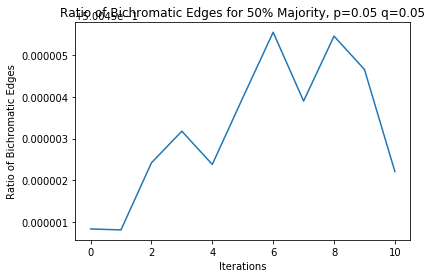

In [599]:
plot_bichromatic_ratios_sbm(50, 1000, .5, [[0.05, 0.05],[0.05, 0.05]], 10, 1)

In [610]:
def get_ave_value(key_range, d):
    values = []
    for key in key_range:
        values.append(d[key])
    return np.average(values)

In [631]:
def plot_degree_centrality(graph_size, probs):
    maj_ave_degree = []
    min_ave_degree = []
    maj_min_ratios = np.arange(.5, 1, .05)
    for maj_min_ratio in maj_min_ratios:
        size_maj = int(maj_min_ratio * graph_size)
        size_min = int(graph_size - size_maj)
        g = nx.generators.community.stochastic_block_model([size_maj, size_min], probs, seed=seed)
        node_degrees = nx.algorithms.centrality.degree_centrality(g)
        maj_ave_degree.append(get_ave_value(range(size_maj), node_degrees))
        min_ave_degree.append(get_ave_value(range(size_maj, graph_size), node_degrees))
    plt.plot(maj_min_ratios, maj_ave_degree, label="Majority")
    plt.plot(maj_min_ratios, min_ave_degree, label="Minority")
    plt.xlabel("Majority Ratio")
    plt.ylabel("Average Degree Centrality")
    plt.title("Average Degree Centrality, p=" + str(probs[0][0]) + ", q=" + str(probs[0][1]))
    plt.legend()
    plt.savefig("plots/deg_centrality_p=" + str(int(100*probs[0][0])) + "_q=" + str(int(100*probs[0][1])) + "_g" + str(graph_size))
    plt.show()
    return maj_ave_degree, min_ave_degree

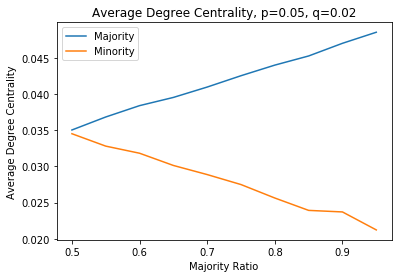

([0.035019019019019021,
  0.036813176813176814,
  0.03838004671338005,
  0.039513359513359513,
  0.040946660946660947,
  0.042511845178511851,
  0.043976476476476484,
  0.045238179355826406,
  0.046986986986986987,
  0.048513776934829562],
 [0.034502502502502495,
  0.032790568346123899,
  0.031809309309309308,
  0.030121550121550125,
  0.02886219552886219,
  0.027483483483483482,
  0.025625625625625627,
  0.023917250583917249,
  0.023703703703703703,
  0.021221221221221217])

In [635]:
plot_degree_centrality(1000, [[0.05, 0.02],[0.02, 0.05]])

In [607]:
np.arange(.5, 1, .1)

array([ 0.5,  0.6,  0.7,  0.8,  0.9])